### Preliminary cell to start the notebook

In [48]:
# libraries
import os
import sys
import platform
print(sys.version)

strong_pc = platform.system() == 'Linux'
in_colab = 'google.colab' in sys.modules
if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    #!pip install tensorflow==2.11.0
    #!pip install tensorflow_text==2.11.0
    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules and False:
        print('Installing keras')
        !pip install keras==2.11.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0


if 'DEEPNOTE_ENV' in os.environ:
    os.chdir('/..')
    os.chdir('datasets')
    os.chdir('googledrivedeepnoteintegration')
    os.chdir('Human_Data_Analytics_Project_2023')
    if not 'librosa' in sys.modules:
        print('Installing Librosa')
        !pip install librosa
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.models import load_model

# GPU SETTINGS FOR LINUX and repressing warnings for windows. References for gpu: https://www.tensorflow.org/guide/gpu
show_gpu_activity = False
if sys.platform == 'linux' and not in_colab:
    if show_gpu_activity:
        tf.debugging.set_log_device_placement(True)

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
    # Restrict TensorFlow to only allocate a part of memory on the first GPU
        try:
            tf.config.set_logical_device_configuration(
                gpus[0],
                [tf.config.LogicalDeviceConfiguration(memory_limit=6800)])
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)
else:
    warnings.filterwarnings("ignore", category=UserWarning)

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'Data', 'ESC-10-depth')
samplerate = 22500

3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]
TensorFlow version: 2.12.0
keras version = 2.12.0


In [49]:
main_dir = os.getcwd()
subfolder_path = os.path.join(main_dir, 'Data','balanced')

## Dataset management

Function to delete all the files which are too short or too long, we keep 10 sec files and we will sample half times

In [12]:
from pydub import AudioSegment

# Function to check audio duration
def check_audio_duration(audio_path, target_duration):
    try:
        audio = AudioSegment.from_file(audio_path)
        duration_seconds = len(audio) / 1000  # Convert milliseconds to seconds
        return duration_seconds == target_duration  # Check if duration is exactly equal to the target duration
    except Exception as e:
        return False


# Set the root folder path
root_folder = os.path.join(main_dir, 'Data', 'AudioSet')

# Target duration in seconds    
target_duration = 10
file_count = 0
remode_file = 0

# Iterate through all files in the directory and its subdirectories
for root, dirs, files in os.walk(root_folder):
    for file in files:
        # Check if the file has an audio file extension (e.g., .mp3, .wav, .ogg, etc.)
        if file.endswith(('.mp3', '.wav', '.ogg', '.flac', '.aac')):
            audio_path = os.path.join(root, file)
            file_count += 1
            if not check_audio_duration(audio_path, target_duration):
                # delete the file
                os.remove(audio_path)
                remode_file += 1


In [13]:
print(f'Number of files: {file_count}')
print(f'Number of removed files: {remode_file}') # around 3000 files removed


Number of files: 49625
Number of removed files: 2885


Renaming the folders from name = label, to name = number in order to use US_training (modified into AS_training)

In [17]:
#renaming the folders

import os
# Set the root folder path
path = os.path.join(main_dir, 'Data', 'AudioSet')
count = 1
for folder_name in sorted(os.listdir(path)):
    if os.path.isdir(os.path.join(path, folder_name)):
        # Create a new name with a three-digit number
        new_name = f"{count:03d}"
        
        # Construct the full paths to the old and new folders
        old_folder_path = os.path.join(path, folder_name)
        new_folder_path = os.path.join(path, new_name)
        
        # Rename the subfolder
        os.rename(old_folder_path, new_folder_path)
        
        count += 1

Converting wav files if needed (skipped)

In [38]:
# If we want to convert the audio files to OGG format, we can use the following code:
# But we do not do it because it takes too long, instead we use the original files modifying the function create_dataset

# Set the root folder path
root_folder = os.path.join(main_dir, 'Data', 'AudioSet')

# Iterate through all files in the directory and its subdirectories
for root, dirs, files in os.walk(root_folder):
    for file in files:
        # Check if the file has a WAV file extension
        if file.endswith('.wav'):
            # Construct the full path to the file
            file_path = os.path.join(root, file)
            
            # Specify the output OGG file path
            ogg_file_path = file_path.replace('.wav', '.ogg')
            
            # Use VLC to convert WAV to OGG format with a timeout of 60 seconds
            vlc_command = [
                '/Applications/VLC.app/Contents/MacOS/VLC',
                '--intf', 'dummy',  # Use the dummy interface (no GUI)
                '--no-sout-video',  # Disable video output
                '--sout', f'#transcode{{acodec=vorb,ab=128,channels=2,samplerate=44100}}:std{{access=file,mux=ogg,dst="{ogg_file_path}"}}',
                file_path  # Input WAV file
            ]
            
            # Run the VLC command with a timeout
            try: 
                completed_process = subprocess.run(vlc_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, timeout=0.5)
            except subprocess.TimeoutExpired:
                #check if there exists a file with the same name and its weight is not 0
                if os.path.exists(ogg_file_path) and os.path.getsize(ogg_file_path) > 0:
                    #print(f'Converted "{file_path}" to "{ogg_file_path}"')
                    continue
                else:
                    try:
                        completed_process = subprocess.run(vlc_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, timeout=1)
                    except subprocess.TimeoutExpired:
                        if os.path.exists(ogg_file_path) and os.path.getsize(ogg_file_path) > 0:
                            #print(f'Converted "{file_path}" to "{ogg_file_path}"')
                            continue
                        else: 
                            try:
                                completed_process = subprocess.run(vlc_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, timeout=10)
                            except subprocess.TimeoutExpired:
                                if os.path.exists(ogg_file_path) and os.path.getsize(ogg_file_path) > 0:
                                    #print(f'Converted "{file_path}" to "{ogg_file_path}"')
                                    continue
                                else:
                                    print(f'Failed to convert "{file_path}" to "{ogg_file_path}"')
                                    continue
                    continue

## Autoencoder training (using 3.3)

In [50]:
preprocessing = 'STFT'
AE_name = 'AE_Conv_prep_flatten_'+preprocessing + '_AudioSet'

In [51]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = [ AE_name+'_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")


Created AE_Conv_prep_flatten_STFT_AudioSet_count.txt with content '0' in folder Saved_Models


In [52]:
# Now, you have a TensorFlow dataset with spectrograms and labels.
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import librosa
from scipy.interpolate import RegularGridInterpolator

In [53]:
def create_AS_dataset(folder,val_split = 0.25): #folder = '001'
    # Create an empty list to store spectrograms and labels
    spectrograms = []

    # Define the target shape for spectrograms
    target_shape = (64, 128)

    list_audio_files = os.listdir(os.path.join(main_dir, 'Data', 'AudioSet', folder))

    for audio_file in list_audio_files:
        audio_path = os.path.join(main_dir, 'Data', 'AudioSet', folder , audio_file)
        audio, sr = librosa.load(audio_path, sr=22050, mono=True)
        stft = librosa.stft(audio)

        # Create a grid of indices for the original spectrogram
        x = np.linspace(0, stft.shape[1] - 1, stft.shape[1])
        y = np.linspace(0, stft.shape[0] - 1, stft.shape[0])

        # Create the interpolator function
        interpolator = RegularGridInterpolator((y, x), stft)

        # Create a grid of indices for the target shape
        target_x = np.linspace(0, stft.shape[1] - 1, target_shape[1])
        target_y = np.linspace(0, stft.shape[0] - 1, target_shape[0])

        # Create a meshgrid of target indices
        target_x, target_y = np.meshgrid(target_x, target_y)

        # Stack the indices as a 2D array
        target_indices = np.vstack((target_y.ravel(), target_x.ravel())).T

        # Interpolate to get the resized STFT
        stft = interpolator(target_indices).reshape(target_shape)

        # Change dim to (64, 128, 1)
        stft = stft.reshape(64, 128, 1)

        # Append the spectrogram and label to the lists (modify this part to include labels)
        spectrograms.append(stft)

    # Convert the lists to numpy arrays
    spectrograms = np.array(spectrograms)

    # for entry of each spectrogram take the norm since it is a complex number
    spectrograms = np.abs(spectrograms)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((spectrograms,spectrograms))

    # Shuffle and batch the dataset (modify batch size and buffer size as needed)
    batch_size = 32
    buffer_size = 1000

    #divide into train, val, test
    dataset = dataset.shuffle(buffer_size)
    n = len(dataset)
    n_val = int(n*val_split)
    n_test = int(n*val_split)
    n_train = n - n_val - n_test
    train = dataset.take(n_train)
    val = dataset.skip(n_train).take(n_val)
    test = dataset.skip(n_train+n_val).take(n_test)
    
    #batch the dataset
    train = train.batch(batch_size)
    val = val.batch(batch_size)
    test = test.batch(batch_size)

    INPUT_DIM = spectrograms[0].shape

    return train, val, test, INPUT_DIM

In [54]:
train, val, test, INPUT_DIM = create_AS_dataset('001')

In [55]:
def num_3(i):
    if i<10:
        return '00'+str(i)
    elif (i<100) and (i>=10):
        return '0'+str(i)
    else:
        return str(i)

In [56]:
#General function to build an autoencoder
#CONVOLUTIONAL AUTOENCODER WITH VECTORIAL CODE
code_size = 32
n_layers = 2
n_units = 32

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_size = code_size,
                      activation = 'tanh',
                      padding = 'valid',
                      n_layers = n_layers, #max number of layers is 3
                      n_units = n_units,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
                      AE_name = AE_name
 ):
    lr = learning_rate
    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))
    for i in range(n_layers):
        encoder.add(layers.Conv2D(n_units * (i+1), kernel_size,strides = strides, activation = activation, padding=padding))
        encoder.add(layers.MaxPool2D(max_pooling, padding='same'))
        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    # flatten layer to get the code
    my_shape = encoder.layers[-1].output_shape
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size,activation = activation, activity_regularizer=keras.regularizers.l1(regularizer)))

    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(code_size))
    decoder.add(layers.Dense(np.prod(my_shape[1:]), activation=activation))
    decoder.add(layers.Reshape(my_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):
        filters = n_units * (n_layers-i) if i<n_layers-1 else 1
        decoder.add(layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, padding=padding))
        decoder.add(layers.UpSampling2D(size=max_pooling))
        if batch_norm:
            decoder.add(layers.BatchNormalization())

    #final reshape
    decoder.add(tf.keras.layers.Resizing(height = INPUT_DIM[0], width = INPUT_DIM[1], interpolation="bilinear", crop_to_aspect_ratio=False))

    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = AE_name)

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    loss = loss
    metrics = metrics

    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder


In [57]:
def AS_training(AE_name,
                autoencoder,
                n_folders,
                epochs = 50,
                preprocessing = None,
                patience=10,
                verbose = 0,
                ndim = 3,
                metrics = ['mse'],
                ):

    #paramteres for the fit and callbacks
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                mode='max',
                                                verbose=verbose,
                                                restore_best_weights=True,
                                                patience=patience)]

    #read the file txt to know the folder to start 
    with open(os.path.join(main_dir,'Saved_Models',AE_name+'_count.txt'), 'r') as file:
        last_folder = int(file.read())
        print(f'Last folder trained: {last_folder}')

    if n_folders < last_folder:
        print('The number of folders is smaller than the last folder trained!')
        n_folders = last_folder
    
    for i in range(last_folder+1,n_folders+1):

        #load the model if i > 1
        if i>1:
            autoencoder = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))

        #create the dataset

        train, val, test, INPUT_DIM =  create_AS_dataset( folder = num_3(i), val_split = 0.25)
        
        #fit the autoencoder
        history = autoencoder.fit(train, validation_data= val, epochs=epochs, callbacks = callbacks, verbose=0)

        #save the model
        autoencoder.save(os.path.join(main_dir,'Saved_Models',AE_name), save_format  ='keras')

        #show the best epoch
        val_acc_per_epoch = history.history['val_'+metrics[0]]
        best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
        if verbose > 0:
            print('Best epoch: %d' % (best_epoch,))
        
        if verbose > 1:
            #plot the history of the training
            plot_history(history)

            #evaluate the model on the test set
            scores = autoencoder.evaluate(test, return_dict=False)
            display(scores)

        #update the number on the txt file overwritting the previoAS one
        with open(os.path.join(main_dir,'Saved_Models',AE_name+'_count.txt'), 'w') as file:
            file.write(str(i))

    # retrive the size of the model
    print(f"This model has a size of {get_model_size(autoencoder)} MB")
     
    return autoencoder

In [60]:
best_params = {
    'n_layers':1,
    'n_units':16,
    'kernel_size':3,
    'strides':3,
    'max_pooling':3,
    'regularizer':0.0001,
    'padding':'valid',
    'code_size':32,
    'activation':'elu',
    'drop_out':0.0,
    'batch_norm':False,
    'learning_rate':0.005,
}


# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
autoencoder.summary()
verbose=0
if verbose>0:
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()

epochs = 50 #50
n_folders = 528 #528
verbose = 0

AS_training(AE_name = AE_name, autoencoder = autoencoder, epochs = epochs , n_folders = n_folders , preprocessing = preprocessing, ndim=3, verbose=verbose)

Model built with 102257 trainable params
Model: "AE_Conv_prep_flatten_STFT_AudioSet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________
Last folder trained: 288


2023-09-09 23:15:47.671013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:15:47.889229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:15:48.359792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape 

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:15:49.987106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:15:50.212405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:15:50.611357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:15:52.261828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:15:52.469709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:15:52.831518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:17:10.770650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [4841,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:17:11.808181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [4841,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:22.048408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:17:31.034344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [521,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:31.334051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [521,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:17:32.982569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:17:41.407648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [521,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:41.691652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [521,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:43.859130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:17:45.486412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:17:45.703468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:17:46.173437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:17:47.821965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:48.032397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:48.465719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:17:50.013889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:50.223075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:17:50.628675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:17:52.238536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:52.446617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:52.947004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:17:54.587636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:54.795377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:55.226390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:17:56.521063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:56.745718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:57.582429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:17:59.175978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:59.386183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:17:59.834685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:01.430200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:01.636553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:18:02.012480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:03.724783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:03.724965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:18:03.930250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:05.522648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [32,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:18:05.729416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [32,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:06.046926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:07.637273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:18:07.845545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:08.261986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:10.501219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:10.707434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:11.112097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:13.623425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [118,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:13.842455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [118,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:18:14.753453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:19.133818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [240,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:19.379769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [240,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:20.453699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:24.809601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [240,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:25.046563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [240,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:18:25.907174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:27.204835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:18:27.413762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:27.844398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:29.419077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:29.626661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:29.918255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:32.085044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:18:32.293071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:32.743117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:37.230859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [246,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:37.462896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [246,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:18:38.040202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:40.038761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [82,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:40.038945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [82,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:40.250346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:42.236192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:42.442456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:42.844311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:44.343603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:44.560356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:44.930428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:46.329018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:46.543967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:46.870716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:49.022493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:49.229371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:49.677904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:52.331423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [127,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:52.552413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [127,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:53.099534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:18:54.621869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:18:54.831520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:18:55.163020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:00.364950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [297,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:00.624225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [297,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:01.746858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:03.332124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:03.549573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:03.878518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:05.570430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:05.779044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:06.468929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:08.833765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:09.038372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:19:09.418140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:11.226359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [73,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:19:11.437148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [73,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:19:11.976107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:13.510821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:13.716428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:14.193697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:15.767088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:15.973980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:19:16.307696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:17.980085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:19:18.186037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:18.568669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:20.110128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:20.316664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:20.762280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:22.989543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:23.193867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:23.513188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:24.997917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:25.213417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:25.616349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:27.229130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:27.436740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:27.766368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:29.222456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:19:29.438885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:29.767806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:31.364288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:31.582568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:32.031235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:33.478028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:19:33.695004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:34.112979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:36.213509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:36.418093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:36.804314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:38.418338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:38.623457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:39.065373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:40.666264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:40.876622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:41.344838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:44.934485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [180,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:45.163824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [180,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:19:45.661281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:49.245438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [186,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:49.472064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [186,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:49.957182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:52.321701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [107,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:52.539667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [107,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:53.115753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:55.388897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:19:55.389102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:19:55.596453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:57.643229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:19:57.851084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:19:58.201778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:19:59.854172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:00.062927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:00.550100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:02.129366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:20:02.335250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:02.656596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:04.064294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:04.272870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:04.735676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:07.025840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:07.232916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:07.658615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:09.898331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:10.104599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:10.417836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:11.981406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:12.187809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:12.629780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:14.146620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:14.353990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:14.817712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:16.561616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:20:16.768128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:17.238353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:19.243781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [84,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:19.243973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [84,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:19.457460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:21.148987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:21.371296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:21.750072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:23.893637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:24.095367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:24.502859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:26.087776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:20:26.292317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:26.716374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:28.305984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:28.512099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:28.849662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:30.546521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [67,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:20:30.754747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [67,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:31.278590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:32.802490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:33.012845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:33.416355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:35.012416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:35.218786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:35.513706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:37.664526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:20:37.873466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:38.354989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:41.211661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [144,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:41.432156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [144,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:41.956854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:43.508484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:43.714773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:44.002634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:45.394216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:20:45.609292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:45.977852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:47.476569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:47.685500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:48.019936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:49.505988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:49.722666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:50.307920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:52.567757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:52.775070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:20:53.069034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:54.662158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:20:54.868714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:55.188635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:57.020740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:20:57.226755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:57.519457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:20:59.170983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:59.376510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:20:59.776884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:01.422503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:01.632204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:02.130567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:03.702984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:03.915849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:04.290940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:06.474516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:06.726807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:07.061449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:08.719917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:08.927310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:09.274259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:10.816605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:11.023682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:11.400967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:12.884250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:13.096860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:13.467605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:15.002689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:15.210472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:15.526688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:17.156453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:17.361843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:17.653422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:19.691818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:19.898747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:20.388930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:21.998363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:22.204530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:22.494691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:24.063674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:24.267905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:24.640499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:25.958091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:26.181901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [42,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:26.643381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:28.243700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:28.452609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:28.857714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:30.344359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:30.572507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:30.852311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:32.895023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:33.114046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:33.413161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:34.792268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:34.998660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:35.320568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:36.844439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:37.068506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:37.384382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:39.000398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:39.206239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:39.570108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:41.134488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:41.339353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:41.780690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:43.387688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:43.595013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:43.995388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:46.071509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:46.285196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:21:46.638114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:54.723687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [487,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:55.013274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [487,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:56.098386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:57.780713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:57.995818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:21:58.306617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:21:59.823281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:00.036845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [46,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:00.461255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:02.099505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:02.099684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:02.305988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:05.998868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [180,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:06.225151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [180,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:06.741125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:09.052141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:09.258146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:09.552121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:11.255289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:11.462228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:11.884291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:13.476778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:13.684054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:14.117441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:15.671762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:15.878575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:16.176217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:17.803247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:18.012966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:18.447959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:19.747951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [40,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:19.968664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [40,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:20.364258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:22.168531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [36,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:22.372176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [36,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:22.675670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:24.064874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:24.275831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:24.623469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:26.084582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:26.311667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:26.730525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:28.156090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:28.373166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:28.687702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:30.144757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:30.364188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:30.657456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:32.842533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:33.053972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:33.412164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:36.137222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [90,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:36.350261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [90,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:36.775212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:38.083825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [43,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:38.290884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [43,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:38.655119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:40.200671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:40.411627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:40.743838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:42.197117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:42.413727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:42.737421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:44.146796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:44.364991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:44.667268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:46.012760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:46.223348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:46.499514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:48.661354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:22:48.865651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:49.150517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:50.988839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [72,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:51.196544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [72,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:51.866669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:53.548461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:53.758035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:54.089733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:55.406701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:55.613892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [38,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:55.941800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:22:57.575827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:57.782210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:22:58.273345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:12.727592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [5066,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:13.668153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [5066,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:21.953280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:24.467082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:24:24.675269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:25.066663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:26.538516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:26.756202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:27.107478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:28.636527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:24:28.843817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:29.133224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:30.540369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:30.755450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:31.086120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:32.554929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:32.774663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:24:33.153362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:34.531614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [43,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:34.748101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [43,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:35.183196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:37.202390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:24:37.410827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:37.815350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:39.319924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:39.536211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:39.977364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:41.352572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:41.558650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:41.953404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:43.563208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:24:43.771695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:44.102440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:45.744628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:24:45.950849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:46.259863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:47.909859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:48.116823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:48.474905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:50.695256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:24:50.900715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:51.242737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:52.848568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:53.054281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:53.477271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:54.926842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:55.148698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [50,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:24:55.525134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:57.109456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:24:57.317735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:24:57.821852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:24:59.498249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:24:59.708425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:00.080818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:01.861502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:02.069246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:02.526225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:04.705769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:04.916399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:05.302164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:06.942750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:07.148915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:07.495276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:09.127300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:09.333572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:09.671570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:11.124735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:11.340600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:11.632478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:13.295250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:13.501086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:13.850606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:15.455017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:15.661573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:16.156810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:18.171463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:18.374528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:18.719539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:20.322932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:20.527829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:20.837792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:22.429621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:22.636134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:22.945906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:24.525566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:24.737128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:25.124654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:26.589822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:26.803831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:27.159499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:28.631587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:28.848047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:29.153366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:31.279124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:31.486817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:31.819451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:33.165573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [41,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:33.378481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [41,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:33.689748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:35.334750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:35.541333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:35.876491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:37.528284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:37.734876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:38.087543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:39.706563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:39.916899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:40.245412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:41.510548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [37,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:41.714719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [37,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:42.095792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:44.139482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:44.345667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:44.646112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:46.237148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:46.444162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:46.745147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:48.471848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:48.472042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:48.680073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:50.694293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:50.902755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:51.202732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:52.781121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:52.986151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:53.431009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:54.851707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:55.075418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:25:55.543095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:57.491996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:57.706809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [45,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:58.048682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:25:59.675694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:25:59.882869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:00.296288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:01.925527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:02.130850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:02.445290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:03.951380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:04.165339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:04.524403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:06.704784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [99,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:06.920896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [99,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:07.476246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:09.055523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:09.262258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:09.595730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:11.730408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:11.937509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:12.305664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:13.882015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:14.087121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:14.407273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:15.984738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:16.191193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:16.736282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:20.299837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [184,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:20.530092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [184,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:21.256089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:22.920895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:22.921098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [62,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:23.127719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:25.217383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:25.425243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:25.751257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:28.019170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:28.227718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:28.595274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:30.222845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:30.431018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:30.773584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:32.329837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:32.535195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:32.855370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:34.572155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:34.572343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:34.781122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:37.081240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [69,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:37.288854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [69,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:37.608757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:39.244402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:39.453678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:39.885240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:41.975808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:42.186921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:42.758447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:44.404329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:44.610163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:44.933788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:46.433371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:46.648302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:47.036161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:48.579516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:48.787844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:26:49.377382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:51.054629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:51.054812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [64,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:51.261904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:53.223301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:53.430074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:53.922002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:26:56.040611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:56.248856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [55,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:26:56.655653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:08.693043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [781,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:27:09.031318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [781,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:11.210329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:12.679358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:12.897872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:13.236689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:14.846863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:27:15.059009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:15.415706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:16.897082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:17.117559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:17.467336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:19.114394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:27:19.322965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:27:19.749999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:22.069391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:22.277817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:22.798319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:24.524829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:24.732970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [61,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:25.086493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:27.188705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [90,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:27:27.402526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [90,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:27.896547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:29.422106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:29.631070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:30.031426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:31.604881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:31.813474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:32.124752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:36.562298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [250,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:36.797664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [250,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:37.480430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:39.708999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:39.915446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:40.355811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:42.282125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [80,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:42.495491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [80,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:43.042349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:44.699485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:44.908836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:45.288009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:46.893266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:47.103696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:47.418810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:49.006032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:49.212450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:49.789843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:51.425007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:51.631355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [57,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:52.188134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:54.144575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:54.351452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:54.659378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:55.931761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:56.137705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [39,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:56.440693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:57.806356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:27:58.025364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [48,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:27:58.399972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:27:59.718844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [41,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:27:59.933585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [41,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:00.213647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:01.686013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:01.908032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:02.240287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:03.859757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:28:04.064732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [56,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:28:04.506708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:05.991279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:06.813747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:07.155053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:08.574211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:08.792758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:09.089994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:10.583550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:28:10.801138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [51,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:11.097103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:12.620425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:12.831875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:13.236439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:14.639132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:14.852824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [44,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:15.286623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:16.906769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:17.114025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:17.430716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:20.566394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [159,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:20.794491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [159,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:21.566592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:23.780731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:28:23.987362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:24.415800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:28.881615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [239,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:29.114359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [239,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:29.965233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:32.709573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [135,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:32.928591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [135,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:33.356596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:36.467469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [157,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:36.688824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [157,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:37.756676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does n

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:39.299763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:39.510905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [52,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:39.803473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:41.359267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:41.567018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [58,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:42.028087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:44.203696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:44.410777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [54,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:44.794111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:46.183304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:28:46.413594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [49,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:46.950734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:48.476447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:48.686977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:49.128362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:50.690689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:50.896437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [53,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:28:51.220363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:52.648108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:52.871049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [47,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:53.199147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets
2023-09-09 23:28:54.853397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_0}}]]
2023-09-09 23:28:55.062351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [60,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:28:55.395679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not

INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


INFO:tensorflow:Assets written to: /Users/leonardo/Desktop/HDA/Human_Data_Analytics_Project_2023/Saved_Models/AE_Conv_prep_flatten_STFT_AudioSet/assets


This model has a size of 1.2098770141601562 MB


### Show the reconstruction capabilities of the model

Model: "AE_Conv_prep_flatten_STFT_AudioSet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 11ms/step


2023-09-09 23:49:53.860306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_1}}]]
2023-09-09 23:49:53.860580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [59,64,128,1]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 10ms/step


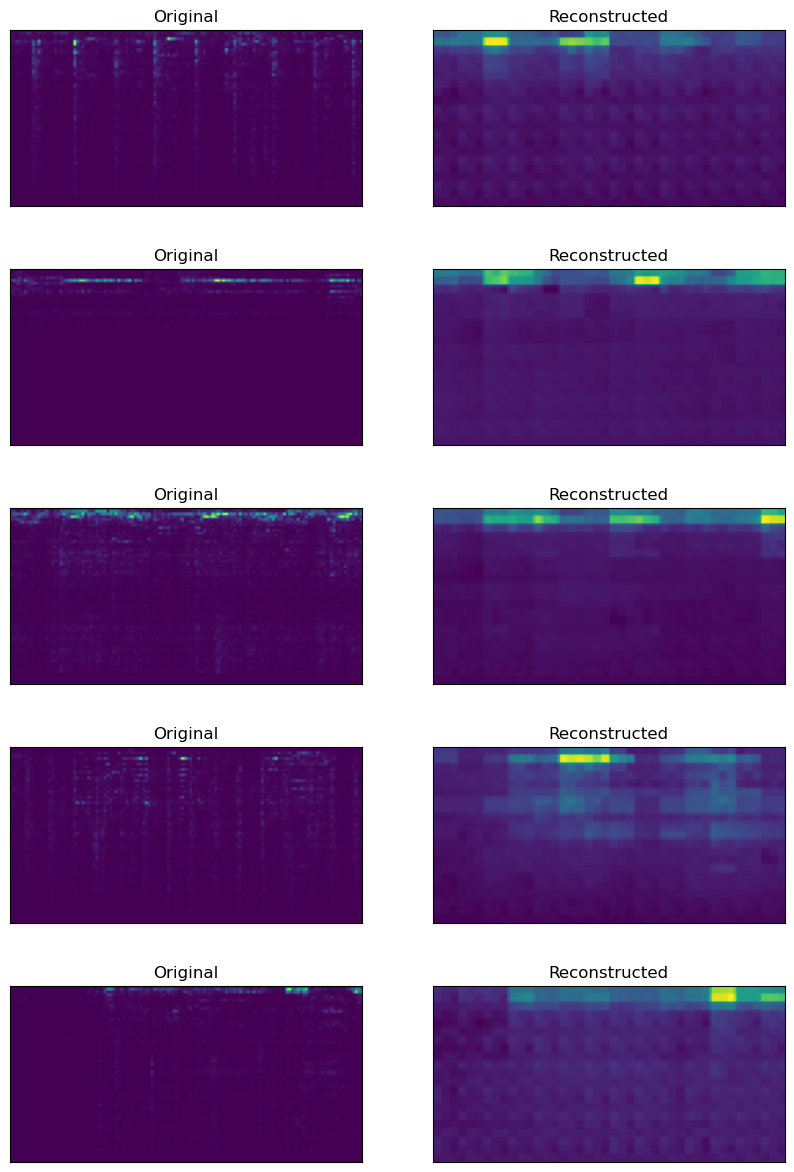

In [61]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)

Now let's see the reconstruction capability on the test set of ESC-10

Found 400 files belonging to 10 classes.


Using 300 files for training.
Using 100 files for validation.


2023-09-09 23:49:54.500497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]
2023-09-09 23:49:54.500672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [300]
	 [[{{node Placeholder/_4}}]]


Model: "AE_Conv_prep_flatten_STFT_AudioSet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                50368     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        51889     
                                                                 
Total params: 102,257
Trainable params: 102,257
Non-trainable params: 0
_________________________________________________________________


2023-09-09 23:49:56.274042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100]
	 [[{{node Placeholder/_4}}]]
2023-09-09 23:49:56.274361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [100]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 10ms/step


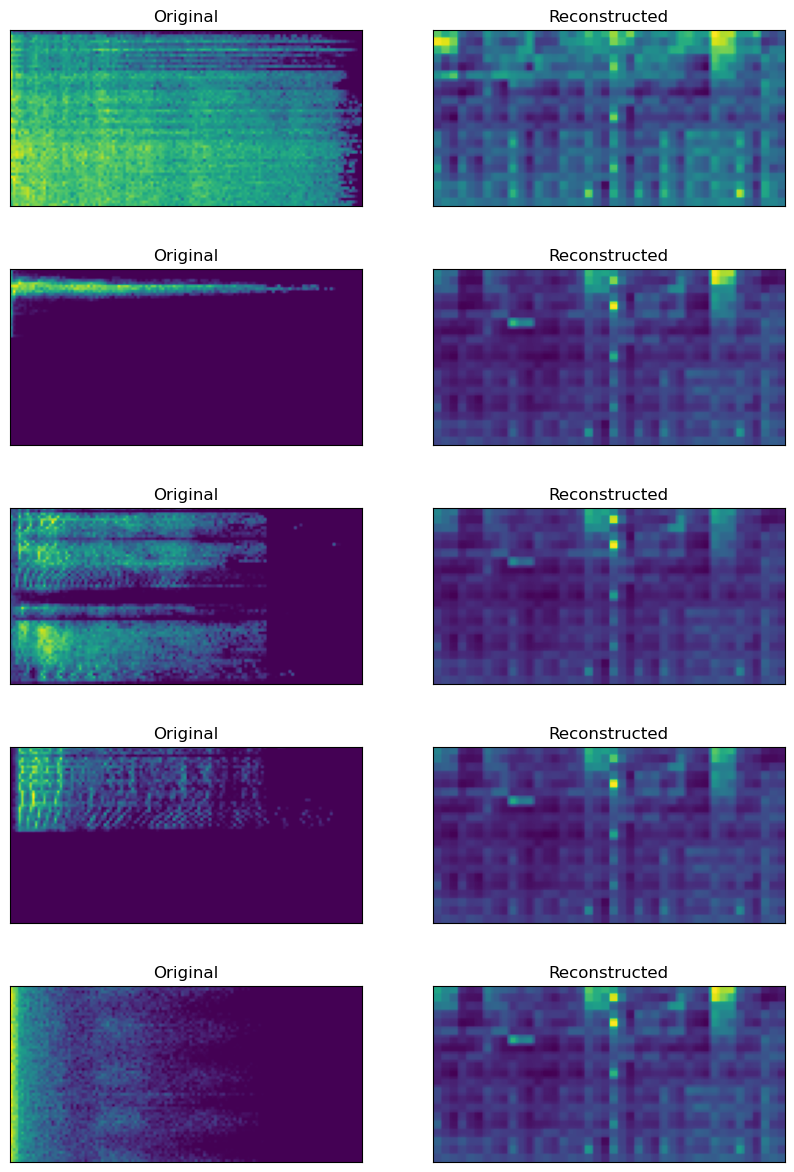

In [62]:
train, val, test, label_names = create_dataset( ESC10_path,
                                                verbose = 0,
                                                batch_size = 30,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = preprocessing,   # "STFT" or "MFCC"
                                                show_example_batch = False,
                                                ndim=3,
                                                resize = True,
                                                new_width = 64,
                                                new_height= 128)
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()
# show n original and reconstructed images
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)